In [1]:
%matplotlib inline
#matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context("talk")

# Keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Scikit Learn
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import confusion_matrix

# others
import pandas as pd
import numpy as np
import pickle as pkl
import uuid

Using TensorFlow backend.


In [88]:
data = pkl.load(open('data_preprocessed.pickle', 'rb'))

/Users/fguimara/.pyenv/versions/3.7.2/envs/pleuraltb/lib/python3.7/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='data_preprocessed.pickle'>
  """Entry point for launching an IPython kernel.


In [200]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    im = ax.matshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           #yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, 
           #yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i , format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.set_yticklabels([''] + classes)

    return ax


In [178]:
"""
Classes for performing the NN training.
"""

import warnings
warnings.filterwarnings('always')

def sp(y_true, y_pred, cut=0.):
    false_output_idx = np.where(y_pred < cut)
    output= np.ones(y_pred.shape)
    output[false_output_idx] = -1
    output = output.T[0]
    cm_ = confusion_matrix(y_true, output)
    cm_ = cm_.astype('float') / cm_.sum(axis=1)[:, np.newaxis]
    if cm_.shape[0] != 1:
        no_class_prob, class_prob = cm_.diagonal()
    else:
        # For the leaveOneOut case
        no_class_prob, class_prob = cm_[0], cm_[0]
    geometric_mean = np.sqrt(no_class_prob * class_prob)
    mean = np.mean([no_class_prob, class_prob])
    SP = np.sqrt(geometric_mean * mean)
    return SP


def sp_max(y_true, y_pred):
    cuts = np.arange(-1., 1., .05)
    sps = [sp(y_true, y_pred, cut)
           for cut in cuts]
    sp_max = np.max(sps)
    sp_max_cut = np.argmax(sps)
    return  sp_max, cuts[sp_max_cut]

In [4]:
def xval_generator(data, k_folds=10):
    """Generator for X-Validation using K-folds approach"""
    skf = StratifiedKFold(n_splits=k_folds)
    X = data['normalized'].values.astype('float32')
    y = data['output'].values.astype('float32')
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        yield X_train, X_test, y_train, y_test

        
def get_model(n_neurons, input_shape):
    # model template
    model = Sequential()

    model.add(Dense(n_neurons,
                    activation='tanh',
                    input_shape=(input_shape,)))
    model.add(Dense(1,
                    activation='tanh',
                    input_shape=(n_neurons,)))
    return model

In [94]:
def load_model(n_neurons, input_shape,ck_filepath):
    model = get_model(n_neurons, input_shape)
    model.load_weights(ck_filepath)  
    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])   
    return model

In [13]:
def run_generator(data, k_folds=5, trials=20, n_neurons=20):
    for neurons in range(1, n_neurons + 1):
        for X_train, X_test, y_train, y_test in xval_generator(data, k_folds):
            input_shape = X_train.shape[1]
            for trial in range(trials):
                yield(X_train, X_test, y_train, y_test, neurons, input_shape, trial)

In [14]:
total_interations = sum(1 for _ in run_generator(data))
print(total_interations)

4000


In [6]:
class ModelSPCheckPoint(ModelCheckpoint):
    """
    Expand model checkpoing callback for calculating best SP
    for the best network setup.
    """
    
    def __init__(self, filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1, **kwargs):
        """"""
        super(ModelSPCheckPoint, self).__init__(filepath,
                                                monitor,
                                                verbose,
                                                save_best_only,
                                                save_weights_only,
                                                mode,
                                                period)
        self.best_sp = -np.inf
        self.best_sp_train = -np.inf
        self.cut = 0.
        self.x_train = kwargs.get('x_train')
        self.y_train = kwargs.get('y_train')
        
    def on_epoch_end(self, epoch, logs={}):
        """
        """
        super(ModelSPCheckPoint, self).on_epoch_end(epoch, logs)

        if self.save_best_only:
            current = logs.get(self.monitor)
            if current == self.best:
                # Compute SP for train data and retrieve best cut
                y_train_pred = self.model.predict(self.x_train)
                sp_train, cut = sp_max(self.y_train, y_train_pred)
                self.best_sp_train = sp_train
                self.cut = cut
                # Compute SP for validation data
                y_pred = self.model.predict(self.validation_data[0])
                y_true = self.validation_data[1]
                self.best_sp = sp(y_true, y_pred, cut=cut)

In [7]:
def run_mlp(X_train, X_test, y_train, y_test,
            n_neurons, input_shape, trial):
    epochs = 1000
    batch_size = 10
    mid =  str(uuid.uuid4())
    model = get_model(n_neurons, input_shape)
    model.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    result_id = '%s.%02d.%04d' % (mid, n_neurons, trial)
    filepath = ".networks/%s.hdf5" % (result_id)
    pklpath = ".networks/%s.p" % (result_id)

    checkpoint = ModelSPCheckPoint(filepath,
                                   monitor='val_loss',
                                   verbose=False,
                                   save_weights_only=True,
                                   save_best_only=True,
                                   mode='min',
                                   x_train=X_train,
                                   y_train=y_train)
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        verbose=False,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpoint])


    checkpoint_file = filepath
    results =  {'id': result_id,
                'cut': checkpoint.cut,
                'val_loss_history': history.history['val_loss'],
                'loss_history': history.history['loss'],
                'n_neurons': n_neurons,
                'checkpoint_file': filepath,
                'sp': checkpoint.best_sp,
                'sp_train': checkpoint.best_sp_train} 
    with open(pklpath, 'wb') as pklfile:
        pkl.dump(results, pklfile, protocol=pkl.HIGHEST_PROTOCOL)
    return (n_neurons, result_id)

In [17]:
from joblib import Parallel, delayed
from tqdm import tqdm_notebook


results = []

with Parallel(n_jobs=-1) as parallel:
     results = parallel(delayed(run_mlp)(X_train, X_test, y_train, y_test, n_neurons, input_shape, trial) 
                        for X_train, X_test, y_train, y_test, n_neurons, input_shape, trial
                        in tqdm_notebook(run_generator(data), total=total_interations))




In [22]:
results = pd.DataFrame(results, columns=['n_neurons', 'id'])
results.to_csv('.networks/results_all.csv')

In [205]:
summary = []
for group_id, group in results.groupby('n_neurons'):
    n_neurons = group.n_neurons.unique()[0]
    for idx in group.id:
        pklpath = f'.networks/{idx}.p'
        with open(pklpath, 'rb') as pklfile:
            res = pkl.load(pklfile)
            summary.append({ 'n_neurons': n_neurons,
                             'id': idx,
                             'sp': res['sp'],
                             'sp_train': res['sp_train']})
summary = pd.DataFrame.from_records(summary)

/Users/fguimara/.pyenv/versions/3.7.2/envs/pleuraltb/lib/python3.7/site-packages/pandas/plotting/_core.py:2254: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


Text(0.5, 0.98, '')

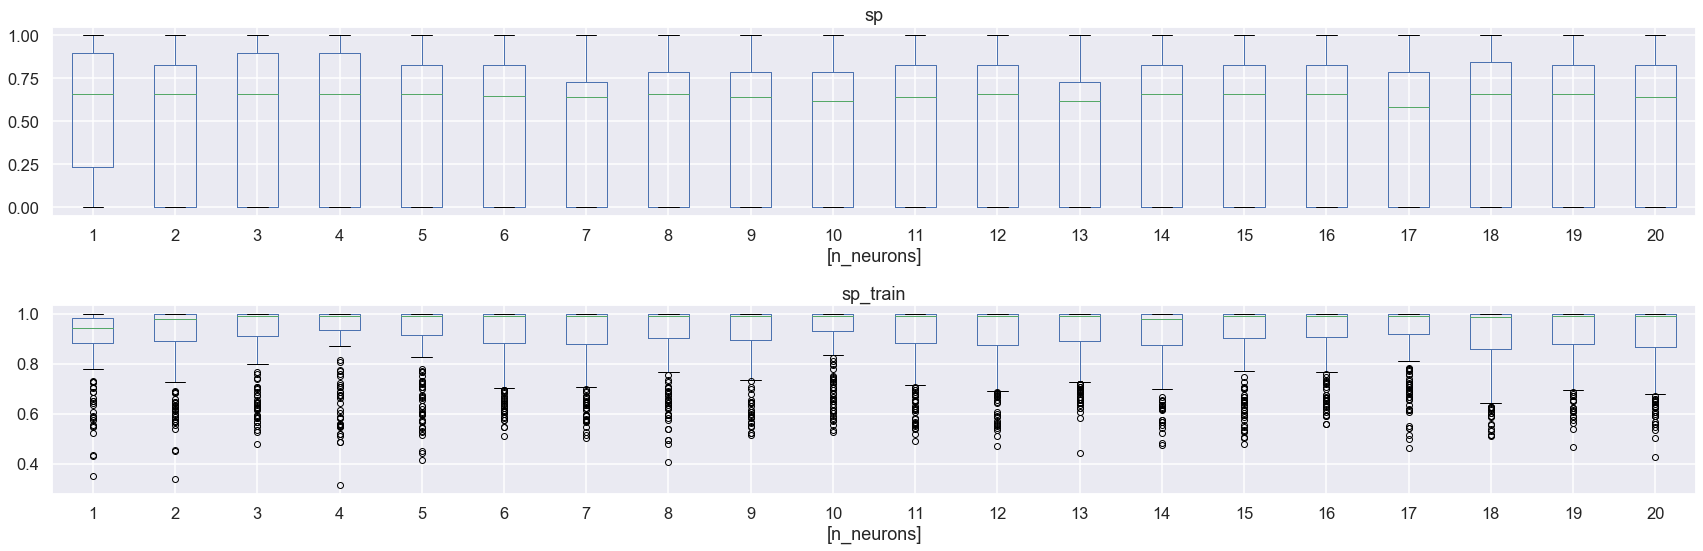

In [206]:
fig, axes = plt.subplots(2, 1, figsize=(24, 8))
summary.boxplot(by='n_neurons', ax=axes)
fig.tight_layout()
fig.suptitle('')

In [231]:
summary[(summary['n_neurons']==4) & (summary['sp']> 0.9)] 

id  n_neurons        sp  \
602  d03ca409-8006-45bc-9753-8dc5cc150d1c.04.0000          4  0.914767   
603  c6b905e8-30ba-4e8c-9df7-e1ce30a64815.04.0000          4  0.914767   
605  257c1a9b-d439-4d3d-a672-e3e5fe25a802.04.0000          4  0.914767   
622  12df9b54-1215-4cff-a87f-4e4bc58c67ca.04.0002          4  1.000000   
627  b25fff36-1d1a-4e71-8e38-854ab50e6ad7.04.0002          4  1.000000   
631  23857a1a-36ad-4566-afe3-7c6deeca7c30.04.0003          4  0.914767   
637  c8529b15-26d6-4835-a064-511b8f47b19a.04.0003          4  1.000000   
642  71fd95f2-19df-4e32-8285-4cc54aa4f171.04.0004          4  0.914767   
649  f0565330-9f39-498d-bce8-29a23d2e319f.04.0004          4  1.000000   
651  d76559a8-200c-4451-a2ec-5baa69322f4d.04.0005          4  1.000000   
653  9b16c572-4398-4cff-b1eb-9c0d1a6d581b.04.0005          4  1.000000   
657  6ab44356-ec30-49ee-84f6-9cd07188798b.04.0005          4  1.000000   
661  d8668242-8eb3-4f3a-a274-e33f44984e1c.04.0006          4  0.914767   
671  632e4579-a95a-48c8-89c3-4ba7bff7d765.04.0007          4  0.914767   
672  01e7082c-dda2-42ba-a600-365dbd51a3d1.04.0007          4  0.914767   
673  aa5c33e4-acca-4e25-be19-305dddaed36c.04.0007          4  1.000000   
674  e90d1739-0b02-4bde-a361-cb040347f276.04.0007          4  1.000000   
681  47ef023a-3ece-4fd9-a1f9-858d67b8f6ec.04.0008          4  1.000000   
684  e7a318ee-8281-42a8-885f-ba49b40248e8.04.0008          4  0.914767   
687  b8707569-4069-4f7a-b703-fe0936fedf70.04.0008          4  1.000000   
692  4e3d7970-49a9-44c5-b361-d57118d9a1a3.04.0009          4  1.000000   
698  71e1e64e-2d94-4a89-8007-00e849fdea18.04.0009          4  1.000000   
701  16dd2534-5e13-4dd7-93f2-a03396c876c9.04.0010          4  1.000000   
703  d82c8b7d-a39f-42f2-886a-055ee583519d.04.0010          4  0.914767   
704  98a8d24f-93ed-4aa4-8ae4-aa174241bf24.04.0010          4  0.914767   
709  6584c8dc-71f6-4e17-9f57-2784792d9530.04.0010          4  1.000000   
711  9a45b0b8-2aff-4b76-a4a4-0488ae5e1013.04.0011          4  1.000000   
722  5dbe6c99-44da-4323-b41f-d2570f005c23.04.0012          4  0.914767   
724  edd6c343-94ed-4974-bd44-c7823004e33f.04.0012          4  0.914767   
728  4c17b554-ee94-4f5c-b1b6-3a3aec61cb8a.04.0012          4  1.000000   
731  5ca7d55c-e083-410c-9215-7f90f602daad.04.0013          4  1.000000   
733  c4a56c6c-81a8-4416-aeeb-9ad18bbfabe6.04.0013          4  1.000000   
734  f6282bb8-0479-4d02-9551-9aed3cec6597.04.0013          4  0.914767   
737  9b7953f5-5352-496c-ba2d-ad16176f2f2d.04.0013          4  1.000000   
744  1f8c9d38-f479-47ed-972b-0f6341c13a5e.04.0014          4  0.914767   
747  ce74e7ef-9dae-4414-8768-f71c3407f13d.04.0014          4  1.000000   
752  49b72761-fe08-4c79-b915-a8347de0c876.04.0015          4  0.914767   
758  8682b512-0ab2-405a-8190-97255b8ea1c2.04.0015          4  1.000000   
761  33ecef0e-8051-45e2-98d2-b4438e1988e9.04.0016          4  0.914767   
762  06c6fd3a-9894-4622-83db-d32413b94dd6.04.0016          4  0.914767   
767  d5a8322b-3665-446f-8828-971219056425.04.0016          4  1.000000   
772  e98212df-e19b-42ef-a21d-55e267f53432.04.0017          4  1.000000   
787  2128bc31-5859-4913-a53f-394d0435bc58.04.0018          4  1.000000   
788  1623f292-b07c-4114-89ae-b6a2979ca6d9.04.0018          4  1.000000   
791  c73f0fc8-ef73-4a1c-b551-8ae08f438dfe.04.0019          4  0.914767   
797  015104af-b57d-43a3-a8d4-3e25b05b41f2.04.0019          4  1.000000   

     sp_train  
602  0.946620  
603  0.969768  
605  1.000000  
622  0.916591  
627  1.000000  
631  1.000000  
637  1.000000  
642  0.873321  
649  0.312635  
651  1.000000  
653  1.000000  
657  1.000000  
661  1.000000  
671  0.989975  
672  0.749165  
673  1.000000  
674  1.000000  
681  1.000000  
684  0.893134  
687  1.000000  
692  0.956524  
698  1.000000  
701  1.000000  
703  0.989975  
704  1.000000  
709  0.510310  
711  1.000000  
722  0.936664  
724  0.956524  
728  0.958826  
731  0.926655  
733  1.000000  
734  1.000000  
737  1.000000  
744  0.9

In [244]:
filepath = ".networks/edd6c343-94ed-4974-bd44-c7823004e33f.04.0012"
best_model  = load_model(4, 87, filepath + '.hdf5')
with open(filepath + ".p", "rb") as pfile:
    res = pkl.load(pfile)

Confusion matrix, without normalization


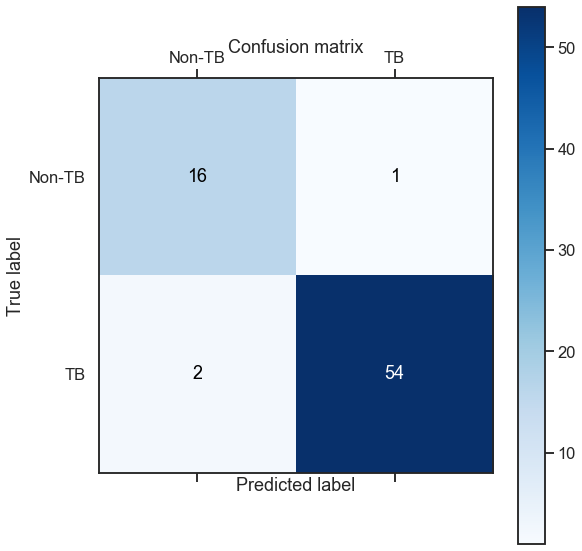

In [245]:
import itertools
import numpy as np
y_pred_out = best_model.predict(data['normalized'].values).reshape(-1)
y_pred = 2 * (y_pred_out > res['cut']) - 1
y_test = data['output'].values


with sns.axes_style('white'):
    sns.set_context("talk")
    ax = plot_confusion_matrix(y_test, y_pred, classes=['Non-TB', 'TB'],
                               title='Confusion matrix')


Text(0.5, 1.0, 'Saída para os dados')

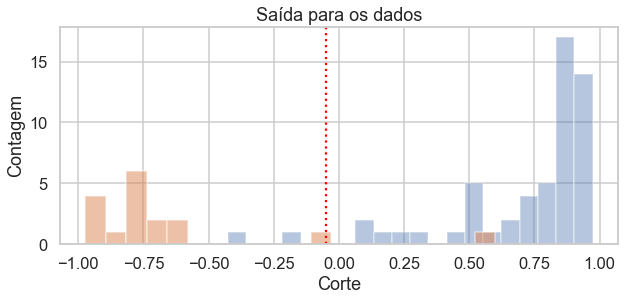

In [292]:
sns.set_context('talk')
sns.set_style('whitegrid')


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(y_pred_out[np.where(y_test > res['cut'])[0]], alpha=.4, bins=20)
ax.hist(y_pred_out[np.where(y_test < res['cut'])[0]], alpha=.5, bins=20)
ax.axvline(res['cut'], linestyle=':', color='red')
ax.set_xlabel('Corte')
ax.set_ylabel('Contagem')

ax.set_title('Saída para os dados')

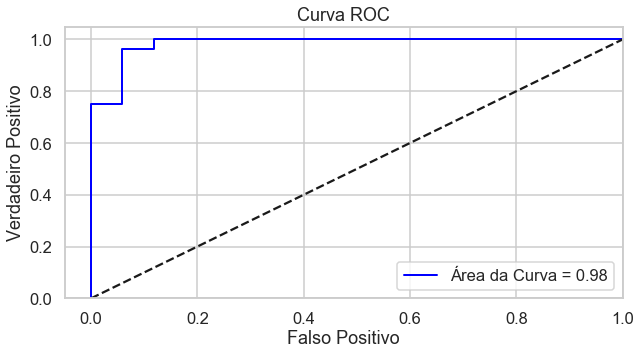

In [290]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_pred_out, drop_intermediate=False)
roc_auc = auc(fpr, tpr)
sns.set_context('talk')
sns.set_style('whitegrid')


fig, ax = plt.subplots(1,1, figsize=(10, 5))
lw = 2

ax.plot(fpr, tpr, color='blue',
         lw=lw, label='Área da Curva = %0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Falso Positivo')
ax.set_ylabel('Verdadeiro Positivo')
ax.set_title('Curva ROC')
plt.legend(loc="lower right")
